In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [8]:
file1 = 'ITK_Images/head_affine_fix.png'
file2 = 'ITK_Images/head_affine_mov.png'
fixed = sitk.ReadImage(file1, sitk.sitkFloat32)
moving = sitk.ReadImage(file2, sitk.sitkFloat32)
# command that will allow us to print and save our cost function as it evolves.
def command_iteration(method):
    #print(f"Iteration{method.GetOptimizerIteration():3} : Cost = {method.GetMetricValue():10.5f} : {method.GetOptimizerPosition()}")
    print(f"Iteration{method.GetOptimizerIteration():3} : Cost = {method.GetMetricValue():10.5f}")
    cost.append(method.GetMetricValue())


In [135]:
cost =[]
metric_flag = 1 # metric_flag = 1 for cross-correlation, 0 for MI, and -1 for Mean Squares
optim_flag = 1 # optim_flag = 0 Regular Stepest Descent, and 1 for Conjugate gradient 
interp_flag = 0 #Flag to determine the interpolator 0 for linear, 1 for Bspline
tx = sitk.CenteredTransformInitializer(fixed,moving,sitk.AffineTransform(fixed.GetDimension()))

R = sitk.ImageRegistrationMethod()

if metric_flag == 1:
    R.SetMetricAsCorrelation()
elif metric_flag == 0: 
    R.SetMetricAsJointHistogramMutualInformation()
elif metric_flag == -1:
    R.SetMetricAsMeanSquares()

if optim_flag == 0:
    R.SetOptimizerAsRegularStepGradientDescent(4.0, 1e-6, 200)
elif optim_flag == 1:
    R.SetOptimizerAsConjugateGradientLineSearch(learningRate = 4.0, numberOfIterations = 500)
    
R.SetOptimizerScalesFromPhysicalShift()
R.SetInitialTransform(sitk.AffineTransform(fixed.GetDimension()))
if interp_flag == 0:
    R.SetInterpolator(sitk.sitkLinear)
elif interp_flag == 1:
    R.SetInterpolator(sitk.sitkBSpline)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))
outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")
cost.append(R.GetMetricValue())
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(100)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)
# simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
# simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
# cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)

Iteration  0 : Cost =   -0.51296
Iteration  1 : Cost =   -0.59403
Iteration  2 : Cost =   -0.75415
Iteration  3 : Cost =   -0.77188
Iteration  4 : Cost =   -0.78791
Iteration  5 : Cost =   -0.80777
Iteration  6 : Cost =   -0.83191
Iteration  7 : Cost =   -0.83796
Iteration  8 : Cost =   -0.88237
Iteration  9 : Cost =   -0.90456
Iteration 10 : Cost =   -0.91120
Iteration 11 : Cost =   -0.91208
Iteration 12 : Cost =   -0.92365
Iteration 13 : Cost =   -0.93367
Iteration 14 : Cost =   -0.93843
Iteration 15 : Cost =   -0.94158
Iteration 16 : Cost =   -0.94725
Iteration 17 : Cost =   -0.94837
Iteration 18 : Cost =   -0.95066
Iteration 19 : Cost =   -0.95596
Iteration 20 : Cost =   -0.95795
Iteration 21 : Cost =   -0.95804
Iteration 22 : Cost =   -0.95867
Iteration 23 : Cost =   -0.96243
Iteration 24 : Cost =   -0.96391
Iteration 25 : Cost =   -0.96419
Iteration 26 : Cost =   -0.96643
Iteration 27 : Cost =   -0.96755
Iteration 28 : Cost =   -0.96786
Iteration 29 : Cost =   -0.97898
Iteration 

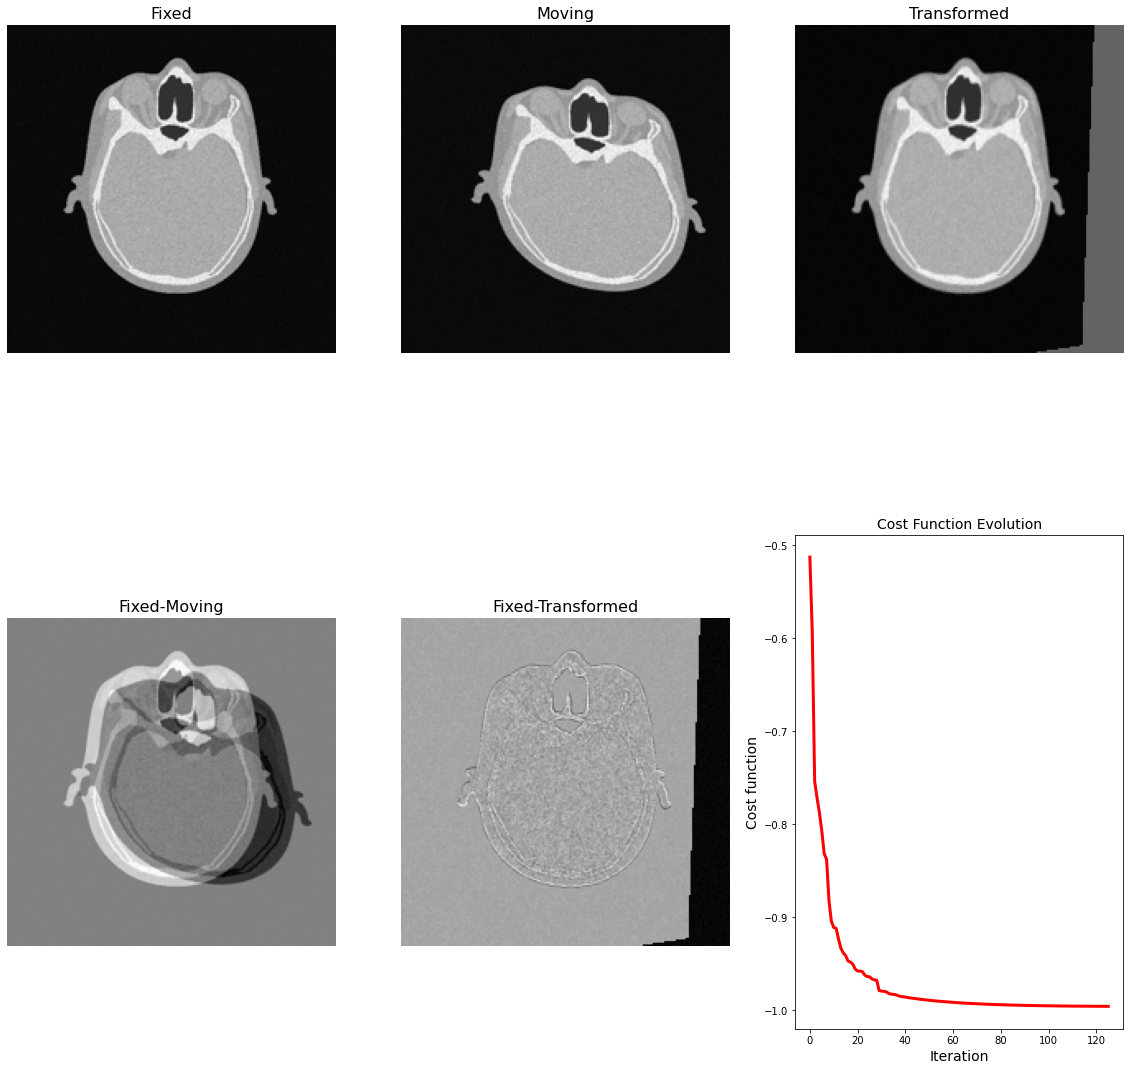

In [136]:
fig, axs = plt.subplots(2,3,figsize = (20,20))
its = np.linspace(1,R.GetOptimizerIteration(),num=R.GetOptimizerIteration())
img_fix = sitk.GetArrayFromImage(fixed)
img_mov = sitk.GetArrayFromImage(moving)
img_out = sitk.GetArrayFromImage(out)

axs[0,0].imshow(img_fix,cmap='gray'); axs[0,0].axis('off'); axs[0,0].set_title('Fixed',fontsize=16)
axs[0,1].imshow(img_mov,cmap='gray'); axs[0,1].axis('off'); axs[0,1].set_title('Moving',fontsize=16)
axs[0,2].imshow(img_out,cmap='gray'); axs[0,2].axis('off'); axs[0,2].set_title('Transformed',fontsize=16)
axs[1,0].imshow(img_fix-img_mov,cmap='gray'); axs[1,0].axis('off'); axs[1,0].set_title('Fixed-Moving',fontsize=16)
axs[1,1].imshow(img_fix-img_out,cmap='gray'); axs[1,1].axis('off'); axs[1,1].set_title('Fixed-Transformed',fontsize=16)


axs[1,2].plot(cost,'r',linewidth=3.0);
axs[1,2].set_title('Cost Function Evolution',fontsize=14);axs[1,2].set_xlabel('Iteration',fontsize=14);
axs[1,2].set_ylabel("Cost function",fontsize=14); 


plt.show()
